In [5]:
import os
import os.path as osp
from glob import glob
from tqdm.auto import tqdm
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
data_dir = '/root/mediazen/speech2anim/essentials'
essentials_dir = [d.path for d in os.scandir(data_dir)]
essentials_dir

['/root/mediazen/speech2anim/essentials/essentials_hynew',
 '/root/mediazen/speech2anim/essentials/essentials_mjki',
 '/root/mediazen/speech2anim/essentials/essentials_LeeYooHonew']

In [3]:
audios, shapes = [], []
for essential in essentials_dir:
    audio_path, shape_path = glob(osp.join(essential, '*.pt'))
    print(audio_path, shape_path)
    audios.append(torch.load(audio_path))
    shapes.append(torch.load(shape_path))

/root/mediazen/speech2anim/essentials/essentials_hynew/audio_ggongggong.pt /root/mediazen/speech2anim/essentials/essentials_hynew/shape_ggongggong.pt
/root/mediazen/speech2anim/essentials/essentials_mjki/audio_ggongggong.pt /root/mediazen/speech2anim/essentials/essentials_mjki/shape_ggongggong.pt
/root/mediazen/speech2anim/essentials/essentials_LeeYooHonew/audio_ggongggong.pt /root/mediazen/speech2anim/essentials/essentials_LeeYooHonew/shape_ggongggong.pt


In [4]:
for audio in audios:
    print(audio[0])
    print(audio[1].shape)
    print(audio[1][:5])
    print(audio[2].shape)
    print(audio[3].shape)
    print(audio[3][:5])
    print()

16000
torch.Size([199])
tensor([0, 1, 2, 3, 4], dtype=torch.int32)
torch.Size([199, 8376, 161])
torch.Size([199])
tensor([4914, 5109, 4786, 4310, 4419], dtype=torch.int32)

16000
torch.Size([200])
tensor([0, 1, 2, 3, 4], dtype=torch.int32)
torch.Size([200, 6553, 161])
torch.Size([200])
tensor([5025, 4974, 4821, 5385, 5099], dtype=torch.int32)

16000
torch.Size([199])
tensor([0, 1, 2, 3, 4], dtype=torch.int32)
torch.Size([199, 7127, 161])
torch.Size([199])
tensor([4259, 4085, 4129, 4421, 4034], dtype=torch.int32)



In [29]:
type(audio[0])

int

In [ ]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

torch.Size([5109, 161])


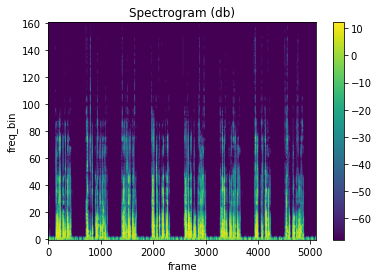

In [13]:
idx = 1

length_wav = audios[0][3][idx]
sample_padded_spec = audios[0][2][idx][:length_wav]

print(sample_padded_spec.shape)
plot_spectrogram(sample_padded_spec.T)

In [32]:
new_audio_tensors = []
index = 0
new_indices = []
new_audio_lengths = []

for audio in audios:
    sample_rate = audio[0]
    indices_tensor = audio[1]
    padded_spec = audio[2]
    spec_length = audio[3]
    
    for spec, length in tqdm(zip(padded_spec, spec_length)):
        new_indices.append(index)
        index += 1
        # padding은 나중에 한꺼번에 다시 해야하므로 unpad
        new_audio_tensors.append(spec[:length])
        new_audio_lengths.append(length)

new_audio_lengths_tensor = torch.IntTensor(new_audio_lengths)
new_stacked_audio_tensors = torch.nn.utils.rnn.pad_sequence(new_audio_tensors, batch_first=True)
new_indices_tensor = torch.IntTensor(new_indices)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [37]:
new_stacked_audio_tensors.shape

torch.Size([598, 8376, 161])

In [40]:
new_audio_data = (
    sample_rate, 
    new_indices_tensor, 
    new_stacked_audio_tensors, 
    new_audio_lengths_tensor
)
new_audio_path = '/root/mediazen/speech2anim/merged_essentials/audio_ggongggong.pt'
torch.save(new_audio_data, new_audio_path)

In [14]:
# check new audio ggongggong

torch.Size([5109, 161])


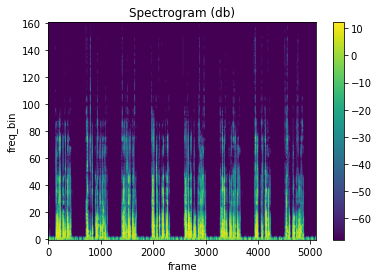

In [19]:
new_audio_path = '/root/mediazen/speech2anim/merged_essentials/audio_ggongggong.pt'

new_audio = torch.load(new_audio_path)
new_audio[2].shape

idx = 1

length_wav = new_audio[3][idx]
sample_padded_spec = new_audio[2][idx][:length_wav]

print(sample_padded_spec.shape)
plot_spectrogram(sample_padded_spec.T)

In [20]:
for shape in shapes:
    print(shape[0].shape) # timecodes
    print(shape[1]) # num of blendshape
    print(len(shape[2])) # col of blendshape
    print(shape[3].shape) # shape
    print(shape[4].shape) # length of shapes
    print()

torch.Size([199, 5028])
61
199
torch.Size([199, 5028, 16])
torch.Size([199])

torch.Size([200, 3936])
61
200
torch.Size([200, 3936, 16])
torch.Size([200])

torch.Size([199, 4280])
61
199
torch.Size([199, 4280, 16])
torch.Size([199])



In [48]:
idx = 0
length_shape = shape[4][idx]

timecodes = shape[0][idx][:length_shape]
shape_value = shape[3][idx][:length_shape]

timecodes.shape, shape_value.shape

(torch.Size([2560]), torch.Size([2560, 16]))

In [57]:
merge = torch.cat([timecodes.unsqueeze(1), shape_value], dim=1)
merge.T.shape

pd.DataFrame(np.array(merge), columns=['Timecodes']+shape[2][0])

,Timecodes,JawForward,JawOpen,MouthClose,MouthFunnel,MouthPucker,MouthDimpleLeft,MouthDimpleRight,MouthStretchLeft,MouthStretchRight,MouthRollLower,MouthRollUpper,MouthShrugLower,MouthShrugUpper,MouthPressLeft,MouthPressRight,CheekPuff
0,2.100001e+10,0.003294,0.002374,0.002946,0.005708,0.006884,0.008802,0.009079,0.009951,0.011504,0.004356,0.003283,0.008004,0.006962,0.010774,0.009568,0.001894
1,2.100001e+10,0.002651,0.001654,0.002180,0.004997,0.006105,0.008265,0.008551,0.008570,0.010078,0.003604,0.002691,0.006957,0.006219,0.009976,0.008783,0.001309
2,2.100001e+10,0.002051,0.000986,0.001465,0.004342,0.005419,0.007796,0.008086,0.007530,0.008995,0.002909,0.002149,0.006147,0.005583,0.009275,0.008090,0.000779
3,2.100001e+10,0.001495,0.000369,0.000800,0.003739,0.004833,0.007384,0.007681,0.006642,0.008089,0.002257,0.001652,0.005511,0.005031,0.008657,0.007479,0.000300
4,2.100001e+10,0.000979,0.000000,0.000191,0.003202,0.004361,0.006982,0.007282,0.005888,0.007311,0.001637,0.001194,0.004987,0.004536,0.008119,0.006945,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2.100424e+10,0.000000,0.000673,0.002117,0.000822,0.001061,0.005688,0.005726,0.008244,0.009347,0.002257,0.002326,0.000000,0.000000,0.003165,0.001972,0.000000
2556,2.100424e+10,0.000000,0.000213,0.001574,0.000507,0.000749,0.005092,0.005125,0.007633,0.008721,0.001734,0.001891,0.000000,0.000000,0.002563,0.001383,0.000000
2557,2.100424e+10,0.000000,0.000000,0.001061,0.000204,0.000438,0.004522,0.004552,0.007048,0.008120,0.001250,0.001492,0.000000,0.000000,0.001990,0.000821,0.000000
2558,2.100424e+10,0.000000,0.000000,0.000621,0.000000,0.000156,0.003988,0.004019,0.006536,0.007595,0.000813,0.001123,0.000000,0.000000,0.001423,0.000263,0.000000


In [21]:
target_shape = shapes[0][2][0]
for shape in shapes:
    for blendshape_column in shape[2]:
        if blendshape_column != target_shape:
            print(blendshape_column) 

In [21]:
blendshape_counts

61

In [29]:
for shape in shapes:
    blendshape_columns = shape[2]
blendshape_columns

(['JawForward',
  'JawOpen',
  'MouthClose',
  'MouthFunnel',
  'MouthPucker',
  'MouthDimpleLeft',
  'MouthDimpleRight',
  'MouthStretchLeft',
  'MouthStretchRight',
  'MouthRollLower',
  'MouthRollUpper',
  'MouthShrugLower',
  'MouthShrugUpper',
  'MouthPressLeft',
  'MouthPressRight',
  'CheekPuff'],
 ['JawForward',
  'JawOpen',
  'MouthClose',
  'MouthFunnel',
  'MouthPucker',
  'MouthDimpleLeft',
  'MouthDimpleRight',
  'MouthStretchLeft',
  'MouthStretchRight',
  'MouthRollLower',
  'MouthRollUpper',
  'MouthShrugLower',
  'MouthShrugUpper',
  'MouthPressLeft',
  'MouthPressRight',
  'CheekPuff'],
 ['JawForward',
  'JawOpen',
  'MouthClose',
  'MouthFunnel',
  'MouthPucker',
  'MouthDimpleLeft',
  'MouthDimpleRight',
  'MouthStretchLeft',
  'MouthStretchRight',
  'MouthRollLower',
  'MouthRollUpper',
  'MouthShrugLower',
  'MouthShrugUpper',
  'MouthPressLeft',
  'MouthPressRight',
  'CheekPuff'],
 ['JawForward',
  'JawOpen',
  'MouthClose',
  'MouthFunnel',
  'MouthPucker',
  '

In [30]:
new_timecode_tensors = []
new_shape_tensors = []
new_shape_lengths = []
new_blendshape_columns = []

for shape in shapes:
    padded_timecodes = shape[0]
    blendshape_counts = shape[1]
    blendshape_columns = list(shape[2])
    padded_blendshape = shape[3]
    shape_lengths_tensor = shape[4]

    new_blendshape_columns += blendshape_columns
    
    for i, (timecode, blendshape, length) in tqdm(enumerate(zip(padded_timecodes, padded_blendshape, shape_lengths_tensor))):
        new_timecode_tensors.append(timecode[:length])
        new_shape_tensors.append(blendshape[:length])
        new_shape_lengths.append(length)

new_stacked_timecode = torch.nn.utils.rnn.pad_sequence(new_timecode_tensors, batch_first=True)
new_blendshape_columns = tuple(new_blendshape_columns)
new_stacked_shapes = torch.nn.utils.rnn.pad_sequence(new_shape_tensors, batch_first=True)
new_shape_lengths_tensor = torch.IntTensor(new_shape_lengths)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [41]:
(
new_stacked_timecode.shape, 
blendshape_counts,
len(new_blendshape_columns), type(new_blendshape_columns), new_blendshape_columns[0][:2],
new_stacked_shapes.shape,
new_shape_lengths_tensor.shape
)

(torch.Size([598, 5028]),
 61,
 598,
 tuple,
 ['JawForward', 'JawOpen'],
 torch.Size([598, 5028, 16]),
 torch.Size([598]))

In [42]:
new_shape_data = (
    new_stacked_timecode, 
    blendshape_counts,
    new_blendshape_columns,
    new_stacked_shapes,
    new_shape_lengths_tensor
)
new_shape_path = '/root/mediazen/speech2anim/merged_essentials/shape_ggongggong.pt'
torch.save(new_shape_data, new_shape_path)